
MinimisingOracul
+--------------------------------------------------+-----------------+---------------+--------------+-------------+-------------+---------------------+--------------------+---------------------+
| Method name                                      |   ExecutionTime | RAMSize       |   EpochCount |   StepCount |   CallCount |   GradientCallCount |   HessianCallCount |   AbsolutePrecision |
+==================================================+=================+===============+==============+=============+=============+=====================+====================+=====================+
| GradientDescent(100,GoldenRatioMethod,eps=1e-11) |       0.397207  | 1.03515625 Mb |           39 |          79 |        5135 |                  79 |                  0 |             1.41421 |
+--------------------------------------------------+-----------------+---------------+--------------+-------------+-------------+---------------------+--------------------+---------------------+
| Wolfe

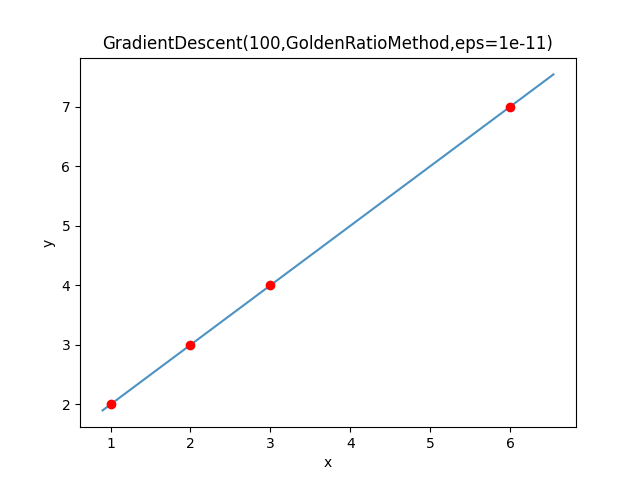

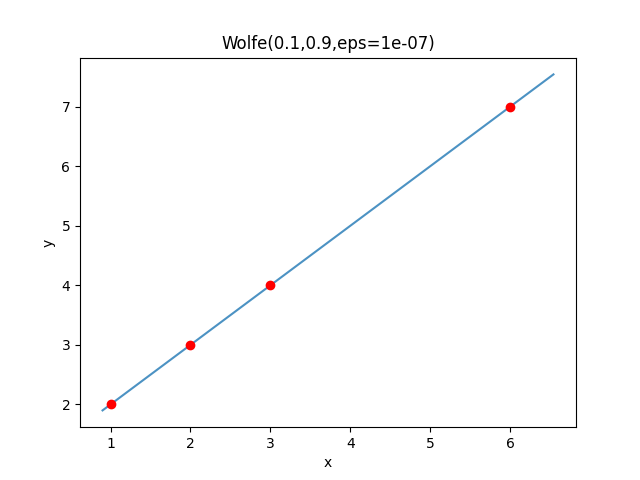

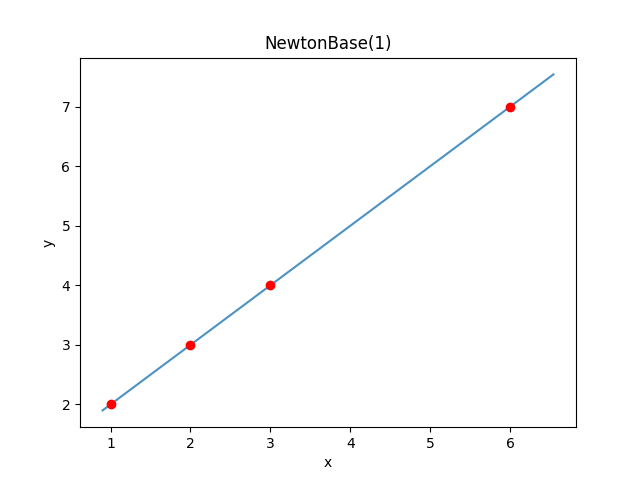

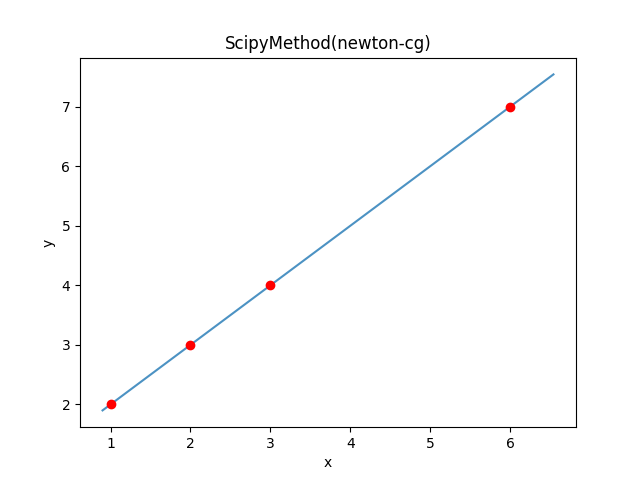

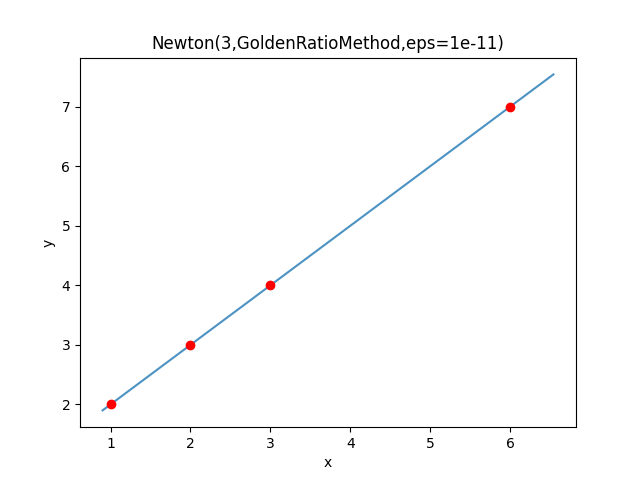

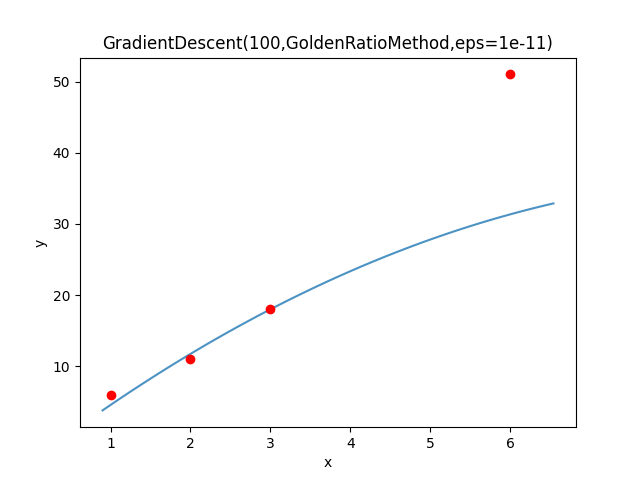

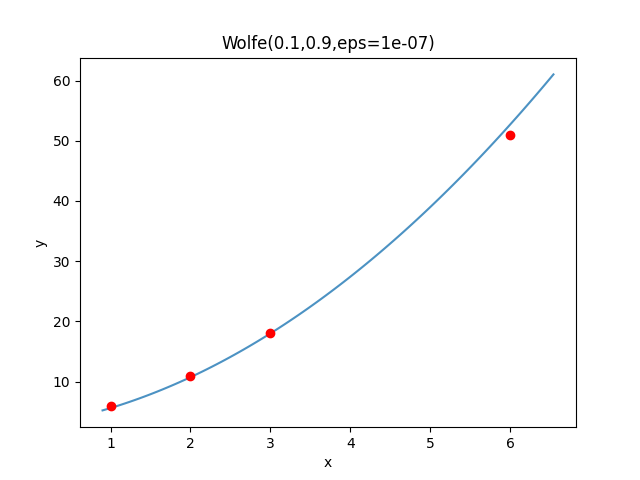

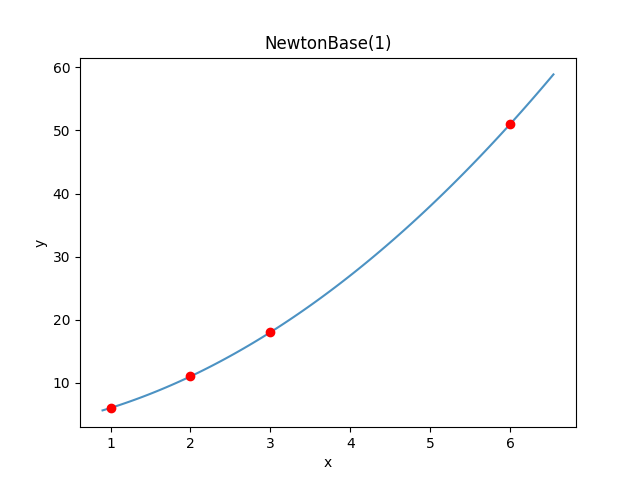

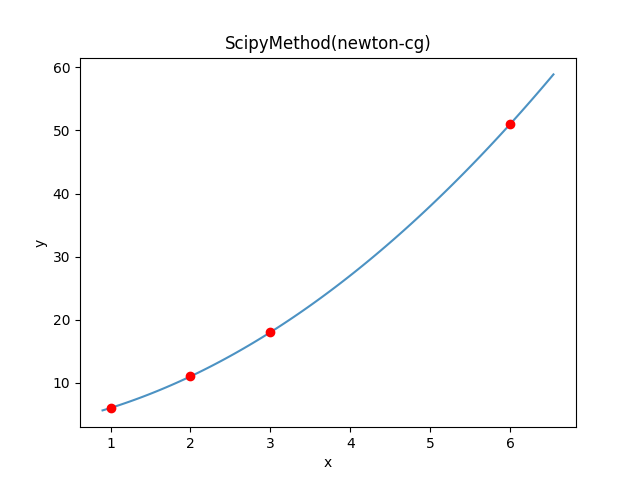

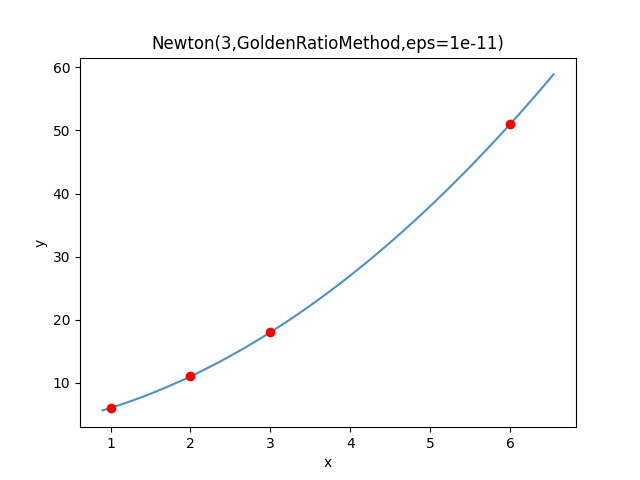

In [1]:
%matplotlib widget
import time

import matplotlib.pyplot as plt
import numpy as np
import sympy
from src.v2.impl.conditions import StepCountCondition, PrecisionCondition, AbsolutePrecisionCondition
from src.v2.impl.function_interpretations import LinearInterpretation, PolynomialInterpretation
from src.v2.impl.loss_functions import MSE
from src.v2.impl.methods import CoordinateDescent, GoldenRatioMethod, NewtonWolfe
from src.v2.impl.metrics import StepCount, CallCount, GradientCallCount, HessianCallCount, PrecisionCount, \
    AbsolutePrecisionCount, AbsolutePrecision, MinAbsolutePrecision, RAMSize, ExecutionTime, EpochCount
from src.v2.impl.oraculs import LambdaOracul, SymbolOracul, MinimisingOracul
from src.v2.runner.debug import FULL_DEBUG
from src.v2.runner.runner import Runner, FULL_VISUALIZE, NO_VISUALIZE, FULL_ANIMATION, VISUALIZE_FUNCTION, VISUALIZE
from src.v2.visualization.animation import Animator
from src.v2.runner.runner import TABLE
from src.v2.impl.methods import GradientDescent, ScipyMethod, Newton, NewtonBase
from IPython.display import display, HTML

display(HTML("<style>pre { white-space: pre !important; }</style>"))


def print_points(data):
    for i in data:
        print(i[0] + i[1])


x, y, z = sympy.symbols('x, y, z')
base = LambdaOracul(lambda x, y: (x - 10) ** 2 + (y - 5) ** 2)
base_absolute = SymbolOracul((x - 10) ** 2 + (y - 5) ** 2, ['x', 'y'])
bute = LambdaOracul(lambda x, y: (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2)
bute_absolute = SymbolOracul((x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2, ['x', 'y'])
rosenbrok = LambdaOracul(lambda x, y: (1 - np.float64(x)) ** 2 + 100 * (np.float64(y) - np.float64(x) ** 2) ** 2)
rosenbrok_absolute = SymbolOracul((1 - x) ** 2 + 100 * (y - x ** 2) ** 2, ['x', 'y'])
bil = LambdaOracul(lambda x, y: (1.5 - np.float64(x) + np.float64(x) * np.float64(y)) ** 2 + (
        2.25 - np.float64(x) + np.float64(x) * np.float64(y) ** 2) ** 2 + (
                                        2.625 - np.float64(x) + np.float64(x) * np.float64(y) ** 3) ** 2)
hard_non_poly = LambdaOracul(
    lambda x, y: np.sqrt(np.float64(x) ** 2 + np.float64(y) ** 2) - np.sin(np.float64(x) + np.float64(y)) ** 2)
macCormic = LambdaOracul(
    lambda x, y: np.sin(x + y) + (np.float64(x) - np.float64(y)) ** 2 - 1.5 * np.float64(x) + 2.5 * np.float64(y) + 1)
base_non_poly = LambdaOracul(
    lambda x, y: np.exp(np.abs(x, dtype=np.float64), dtype=np.float64) + np.exp(np.abs(y, dtype=np.float64),
                                                                                dtype=np.float64))

min_bil = [3, 0.5]
min1 = np.array([10, 5])
oraculs_rosenbrok = [rosenbrok]
min2 = [1, 1]
oraculs_bute = [bute_absolute]
min3 = [1, 3]
oraculs_hard = [base_non_poly, hard_non_poly]
min4 = [0, 0]

metrics_base = [StepCount(), CallCount(), GradientCallCount(), HessianCallCount()]

minPrec = 1e-5
defPrec = 1e-9
maxPrec = 1e-11

abs_metrics1 = metrics_base + [AbsolutePrecisionCount(defPrec, min1), AbsolutePrecision(min1)]
abs_metrics2 = metrics_base + [AbsolutePrecisionCount(defPrec, min2), AbsolutePrecision(min2)]
abs_metrics3 = metrics_base + [AbsolutePrecisionCount(defPrec, min3), AbsolutePrecision(min3)]
abs_metrics4 = metrics_base + [AbsolutePrecisionCount(minPrec, min4), AbsolutePrecision(min4)]
abs_metr_bil = metrics_base + [AbsolutePrecisionCount(minPrec, min_bil), AbsolutePrecision(min_bil)]

animations = [Animator()]

conditions = [StepCountCondition(500), PrecisionCondition(defPrec)]

modules = ([ExecutionTime()]
           + [RAMSize()]
           + [EpochCount()]
           + metrics_base
           + conditions
           + [Animator()]
           + [AbsolutePrecision(np.array([1, 2, 3]))]
           )

linear_oracul = MinimisingOracul(
    MSE(),
    LinearInterpretation(),
    np.array([np.array([1.0, 2.0]), np.array([2.0, 3.0]), np.array([3.0, 4.0]), np.array([6.0, 7.0])]),
    2
)

polynomial_oracul = MinimisingOracul(
    MSE(),
    PolynomialInterpretation(),
    np.array([np.array([1.0, 6.0]), np.array([2.0, 11.0]), np.array([3.0, 18.0]), np.array([6.0, 51.0])]),
    3
)

st = time.time()
newton_methods = [
    GradientDescent(learning_rate=100, aprox_dec=1e-11),
    NewtonWolfe(c1=0.1, c2=0.9, aprox_dec=1e-7, max_iters=20),
    NewtonBase(1),
    ScipyMethod("Newton-CG"),
    Newton(aprox_dec=maxPrec),
]
point = np.array([10.2, 32.5, 2.0])
result = Runner.run(newton_methods, [linear_oracul, polynomial_oracul], point, modules, precision=defPrec,
                    # **FULL_DEBUG,
                    **TABLE,
                    **VISUALIZE,
                    # **FULL_VISUALIZE,
                    # **FULL_ANIMATION,
                    **VISUALIZE_FUNCTION
                    )
print(result)
print(time.time() - st)
